In [24]:
# importing the modules
import os
import os.path 
import cv2
import tkinter as tk
import tkinter.filedialog as fd
from PIL import Image
from skimage import transform, img_as_int, exposure
import skimage.io as io
import tkinter.messagebox as mb
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log, blob_doh, blob_dog
from scipy import ndimage, spatial
from cmath import inf
import sys
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from skimage import transform
import Polywarp

def polywarp(xi,yi,xo,yo,degree=1):
    """
    Fit a function of the form
    xi[k] = sum over i and j from 0 to degree of: kx[i,j] * xo[k]^i * yo[k]^j
    yi[k] = sum over i and j from 0 to degree of: ky[i,j] * xo[k]^i * yo[k]^j
    Return kx, ky
    len(xo) must be greater than or equal to (degree+1)^2
    """
    if len(xo) != len(yo) or len(xo) != len(xi) or len(xo) != len(yi):
        print ("Error: length of xo, yo, xi, and yi must be the same")
        return
    if len(xo) < (degree+1.)**2.:
        print ("Error: length of arrays must be greater than (degree+1)^2")
        return
    # ensure numpy arrays
    xo = np.array(xo)
    yo = np.array(yo)
    xi = np.array(xi)
    yi = np.array(yi)
    # set up some useful variables
    degree2 = (degree+1)**2
    x = np.array([xi,yi])
    u = np.array([xo,yo])
    ut = np.zeros([degree2,len(xo)])
    u2i = np.zeros(degree+1)
    for i in range(len(xo)):
        u2i[0] = 1.
        zz = u[1,i]
        for j in range(1,degree+1):
            u2i[j]=u2i[j-1]*zz
        ut[0:degree+1,i] = u2i
        for j in range(1,degree+1):
            ut[j*(degree+1):j*(degree+1)+degree+1,i]=u2i*u[0,i]**j
    uu = ut.T
    kk = np.dot(np.linalg.inv(np.dot(ut,uu).T).T,ut)
    kx = np.dot(kk,x[0,:].T).reshape(degree+1,degree+1)
    ky = np.dot(kk,x[1,:].T).reshape(degree+1,degree+1)
    return kx,ky


def find_max (x,y, arr):
    
    print(np.shape(arr))
    print((arr))
    max_elem = -1
    for i in range(x-10, x+11):
        for j in range(y-10, y+11):
            if arr[j][i] > max_elem:
                max_elem =  arr[j][i]

    list_index_max =[(i,j) for i in range(x-20, x+21)  for j in range(y-20, y+21) if arr[j][i]  == max_elem]
    line, column = list_index_max[0]
    return(line, column)
#https://www.geeksforgeeks.org/displaying-the-coordinates-of-the-points-clicked-on-the-image-using-python-opencv/  
# function to display the coordinates of  of the points clicked on the image


def click_event(event, x, y, flags, params):
    global counter
    global green_coord
    global red_coord
    if event == cv2.EVENT_LBUTTONDOWN:   # checking for left mouse clicks
        
        
        print(x,y)   
        x_max,y_max = find_max(x,y,image_array)
        print(x_max, y_max)
        if counter % 2 != 0: 
            red_coord.append(x_max) 
            red_coord.append(y_max-256)
            counter = counter + 1
            print (counter)
        else:
            green_coord.append(x_max) 
            green_coord.append(y_max)
            counter = counter + 1
        cv2.circle(better_contrast_img, (x_max, y_max), 4, (0, 0, 127), 2)
    if event==cv2.EVENT_RBUTTONDOWN:
        counter = 0
        green_coord.clear()
        red_coord.clear()
        

        
        
def blob_detection(img, min_sigma, max_sigma, threshold, method=0):
    """This function is mostly used for detecting the beads in any image.

    Args:
        img_path (string): The absolute path of the input image.
        min_sigma (int): The minimum sigma, lower it is, smaller the blob will be detected.
        max_sigma (int): The maximum sigma, higher it is, bigger the blob will be detected.
        threshold (float): Higher it is, higher the intensities of blobs.
        method (int, optional): 0 for Difference of Gaussian (DoG) and 1 for Determinant of Hessian (DoH). 
        They should be applied with different combination of parameters. DoG is more suitable for fret movies,
        while DoH is more suitable for sequencing images. Defaults to 0.

    Returns:
        centers: A numpy array containing the coordinates of all the centers.
    """
    #img = io.imread(img_path)
    if method == 0:
        blob = blob_dog(
            img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold
        )
    else:
        blob = blob_doh(
            img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold
        )
    i = 0
    # r = 3
    centers = []
    h, w = img.shape
    for blob in blob:
        y, x, r = blob
        if y > r and y < (h - r) and x > r and x < (w - r):
            centers.append(
                ndimage.measurements.center_of_mass(
                    img[int(y - r) : int(y + r + 1), int(x - r) : int(x + r + 1)]
                )
            )
            centers[i] = list(np.add(centers[i], [x - r, y - r]))
            i += 1
    
    return np.array(centers)
 



def show_blob_detection_res(img, min_sigma, max_sigma, threshold, method=0):
    """
    Showing the result of 'blob detection' function. Used as the same way of 'blob_detection'
    """
    fig, ax = plt.subplots()
    #img = io.imread(img_path)
    ax.imshow(img)
    if method == 0:
        res = blob_dog(
            img,
            min_sigma=min_sigma,
            max_sigma=max_sigma,
            threshold=threshold,
        )
    else:
        res = blob_doh(
            img,
            min_sigma=min_sigma,
            max_sigma=max_sigma,
            threshold=threshold,
        )
    i = 0
    CM = []
    r = 3
    [h, w] = img.shape
    for blob in res:
        y, x, r = blob
        # print(r)
        if y > r and y < (h - r) and x > r and x < (w - r):
            CM.append(
                ndimage.measurements.center_of_mass(
                    img[int(y - r) : int(y + r), int(x - r) : int(x + r)]
                )
            )
            CM[i] = list(np.add(CM[i], [y - r, x - r]))
            x1, y1 = CM[i]
            c = plt.Circle([y1, x1], 3, color="red", linewidth=1, fill=False)
            ax.add_patch(c)
            i += 1
    ax.set_axis_off()
    plt.show()

def count_nearest_pts(src, dst, radius):
    """Counting the number of nearest neighbors for each given point.

    Args:
        src (numpy array): (N, 2) shape array. Build the kd tree based on this.
        dst (numpy array): (N, 2) shape array. For each point in this array, find the nearest neighbors in src array.
        radius (int): The maximum searching radius.

    Returns:
        res, idx: res is the distance for the point and its neighbor, 'inf' means no neighbor in given search radius. 
        idx is the index for the neighbor in src array.
    """
    tree = spatial.KDTree(src)
    res, idx = tree.query(dst, k=1, distance_upper_bound=radius)
    for i in range(0, len(idx)):
        if len(np.argwhere(idx == idx[i])) > 1:
            res[i] = inf
    return res, idx

68 137
(512, 512)
[[190 189 188 ... 197 193 195]
 [188 183 181 ... 195 192 190]
 [183 180 180 ... 187 184 189]
 ...
 [249 244 243 ... 181 182 181]
 [211 205 205 ... 169 169 170]
 [167 163 166 ... 172 169 169]]
69 140
61 394
(512, 512)
[[190 189 188 ... 197 193 195]
 [188 183 181 ... 195 192 190]
 [183 180 180 ... 187 184 189]
 ...
 [249 244 243 ... 181 182 181]
 [211 205 205 ... 169 169 170]
 [167 163 166 ... 172 169 169]]
61 391
2
255 66
(512, 512)
[[190 189 188 ... 197 193 195]
 [188 183 181 ... 195 192 190]
 [183 180 180 ... 187 184 189]
 ...
 [249 244 243 ... 181 182 181]
 [211 205 205 ... 169 169 170]
 [167 163 166 ... 172 169 169]]
257 67
249 317
(512, 512)
[[190 189 188 ... 197 193 195]
 [188 183 181 ... 195 192 190]
 [183 180 180 ... 187 184 189]
 ...
 [249 244 243 ... 181 182 181]
 [211 205 205 ... 169 169 170]
 [167 163 166 ... 172 169 169]]
249 317
4
422 210
(512, 512)
[[190 189 188 ... 197 193 195]
 [188 183 181 ... 195 192 190]
 [183 180 180 ... 187 184 189]
 ...
 [249 244

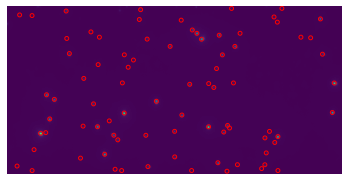

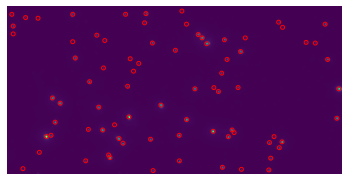

green_coord [[ 69 140]
 [257  67]
 [420 207]]
red_coord [[ 61 135]
 [249  61]
 [413 199]]


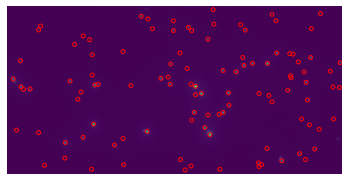

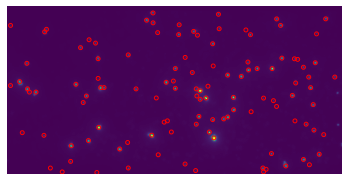

green_coord [[ 69 140]
 [257  67]
 [420 207]]
red_coord [[ 61 135]
 [249  61]
 [413 199]]


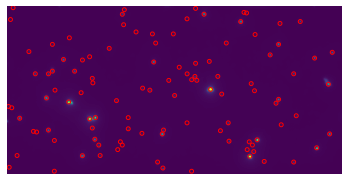

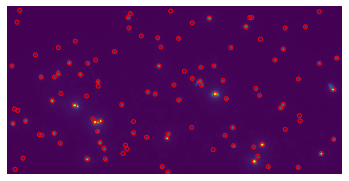

[[-9.61697903e+00 -2.09578262e-02  2.32302136e-04 -5.57814569e-07]
 [ 1.00759118e+00  2.05288455e-04 -1.76266209e-06  3.77321125e-09]
 [-9.19957960e-06 -7.39147816e-07  6.77241722e-09 -1.46418287e-11]
 [ 1.28485693e-09  9.83669011e-10 -9.44626564e-12  2.13587091e-14]]
[[-3.92008721e+00  1.00154382e+00 -2.67583312e-05  9.23405010e-08]
 [-1.00801915e-02  7.15893486e-05 -1.05209458e-06  3.43698816e-09]
 [ 2.75825640e-06 -3.86987434e-07  6.31447787e-09 -2.14477210e-11]
 [ 4.39460356e-09  3.26423970e-10 -7.15178179e-12  2.61619068e-14]]
Mean squared displacement after G to R transformation: 0.41490217189255774
Mean squared displacement after inverse (R to G) transformation: 0.4124772269137637
Mean squared displacement before transformation: 103.09732922084918


In [25]:
root = tk.Tk()
root.attributes("-topmost", True)
root.withdraw()

path = fd.askdirectory(title = "Choose the directory containing beads movies", initialdir = "C:/Users/Anton/Documents/Jupyter home/ExampleData/Test_folder/220717_FC_Nano_200nm_Multicolor/original")

usable_green_beads = np.empty((0, 2))
usable_red_beads = np.empty((0, 2))
#print(usable_green_beads)
#print(usable_red_beads)
os.chdir(path)
green_coord = []
red_coord = []
counter = 0 
for current_dir,dirs, files in os.walk(path) :
    for el in files: 
     #print(dirs)
        if el.split('.')[-1].lower() == 'tif':



            img = io.imread(current_dir + '/' + el) #reading the stack of images
            img1 = np.mean(img, axis = 0) #averaging by the stack
            img1 = img1.astype("ushort") #turn from float format to ushort

            #img = io.imread(current_dir + '/' + el) #initial reading of original averaging image
            #img = cv2.imread(app.st)
            image_array = np.asarray(img1)
            #print(image_array)
            v_min, v_max = np.percentile(image_array, (0.2, 99.8))
            better_contrast_image_array = exposure.rescale_intensity(image_array, in_range=(v_min, v_max))
            better_contrast_img = Image.fromarray(better_contrast_image_array)
            better_contrast_img.save(current_dir + '/'+'better_contrast'+ el[:-4]+'.png')
            better_contrast_img = cv2.imread(current_dir + '/'+'better_contrast' + el[:-4]+'.png')
            #reading by cv2 to make possible circles in color
            #img_jpg = io.imread('C:/Users/panf/Documents/Muscle_intermediates/AVG_G10_1_1_MMStack_Pos0.ome.jpg')
            #img_array = img_as_int(img)

            # displaying the image

            # setting mouse handler for the image
            # and calling the click_event() function

            if counter == 0:
                cv2.namedWindow('image') 
                cv2.setMouseCallback('image', click_event)
                while(1):

                    cv2.imshow('image',better_contrast_img)

                    #if cv2.waitKey(20) & 0xFF == 27: #press Esc to quit
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break


            #cv2.setMouseCallback('image', click_event)
            #cv2.imshow('image', img)   
            #cv2.waitKey(0)
            # wait for a key to be pressed to exit
            img1_green_channel_arr = img1 [0:256, 0:512]
            img1_red_channel_arr = img1 [256:512, 0:512]
            
            img1_red_channel = Image.fromarray(img1_red_channel_arr)
            img1_red_channel.save(current_dir + '/'+'red_channel'+ el[:-4]+'.png')

            
            img1_green_channel = Image.fromarray(img1_green_channel_arr)
            img1_green_channel.save(current_dir + '/'+'green_channel'+ el[:-4]+'.png')

            green_coord = np.reshape(green_coord,(int((counter+1)/2), 2))
            red_coord = np.reshape(red_coord,(int((counter+1)/2), 2))
            print ('green_coord', green_coord)
            print ('red_coord', red_coord)
            tform = transform.estimate_transform('polynomial', src=green_coord, dst=red_coord, order=1)
            tform_inverse = transform.estimate_transform('polynomial', src=red_coord, dst=green_coord, order=1)

            cv2.destroyAllWindows()
            red_channel_centers = blob_detection(
                     img1_red_channel,
                     min_sigma=1,
                     max_sigma=10,
                     threshold=0.001,
                     )
            show_blob_detection_res(
                     img1_red_channel,
                     min_sigma=1,
                     max_sigma=10,
                     threshold=0.001,
                     )

            green_channel_centers = blob_detection(
                     img1_green_channel,
                     min_sigma=1,
                     max_sigma=10,
                     threshold=0.004,
                     )
            show_blob_detection_res(
                     img1_green_channel,
                     min_sigma=1,
                     max_sigma=10,
                     threshold=0.004,
                     )
            green_channel_centers = tform (green_channel_centers)
            res, idx = count_nearest_pts(green_channel_centers, red_channel_centers, 2)

            #usable_green_beads = green_channel_centers[idx[np.where(res != inf)]]
            #print(usable_green_beads)
            #usable_red_beads = red_channel_centers[np.where(res != inf)]
            #print(usable_red_beads)
            ind_red = np.where(res != inf)[0]
            ind_green = idx[np.where(res != inf)]

            usable_green_beads = np.append(usable_green_beads,  green_channel_centers[ind_green], axis=0 )
            usable_red_beads = np.append(usable_red_beads, red_channel_centers[ind_red], axis=0 )

usable_green_beads = tform_inverse(usable_green_beads) #go back to the initial coordinates

order = 3
n_beads = usable_green_beads.shape[0]
#tr1 = transform.PolynomialTransform()
#par1 = np.random.rand(2,int(order+1)*(order+2))
#tr1.params = par1
#dst = tr1(src)
#print(len(src[:,0]),len(src[:,1]),len(dst[:,0]),len(dst[:,1]))

kx,ky = Polywarp.polywarp(usable_red_beads[:,0],usable_red_beads[:,1],usable_green_beads[:,0],usable_green_beads[:,1],degree=order)
print(kx)
print(ky)
tr = transform.PolynomialTransform()
#tr.estimate(src,dst,order = 2)

order1 = 2*order
pidx = 0
par = np.zeros([2,int((order1+1)*(order1+2)/2)])
for j in range(order1 + 1):
    for i in range(j + 1):
        if (j-i)<=order and i<=order:
            par[0, pidx] = kx[j - i,i]
            par[1, pidx] = ky[j - i,i]
        else:
            par[0, pidx] = 0
            par[1, pidx] = 0
        pidx += 1
tr.params = par        

kx,ky = Polywarp.polywarp(usable_green_beads[:,0],usable_green_beads[:,1],usable_red_beads[:,0],usable_red_beads[:,1],degree=order)
tr_inv = transform.PolynomialTransform()
#tr.estimate(src,dst,order = 2)

order1 = 2*order
pidx = 0
par = np.zeros([2,int((order1+1)*(order1+2)/2)])
for j in range(order1 + 1):
    for i in range(j + 1):
        if (j-i)<=order and i<=order:
            par[0, pidx] = kx[j - i,i]
            par[1, pidx] = ky[j - i,i]
        else:
            par[0, pidx] = 0
            par[1, pidx] = 0
        pidx += 1
tr_inv.params = par    


res = np.subtract(tr(usable_green_beads),usable_red_beads)
res = np.multiply(res,res)
print('Mean squared displacement after G to R transformation:',np.sum(res)/n_beads)
res = np.subtract(usable_green_beads,tr_inv(usable_red_beads))
res = np.multiply(res,res)
print('Mean squared displacement after inverse (R to G) transformation:',np.sum(res)/n_beads)
res = np.subtract(usable_green_beads,usable_red_beads)
res = np.multiply(res,res)
print('Mean squared displacement before transformation:',np.sum(res)/n_beads)

np.save('tform_result',tr.params )
np.save('tform_result_inv',tr_inv.params )

#tform_result =  transform.estimate_transform('polynomial', src=usable_green_beads, dst=usable_red_beads, order=2)
#tform_result_inverse = transform.estimate_transform('polynomial', src=usable_red_beads, dst=usable_green_beads, order=3)
#tform_result_params = np.array (tform_result.params )
#tform_result_params_inverse = np.array (tform_result_inverse.params )
#print(tform_result(usable_green_beads))

In [23]:
print(green_coord, red_coord)

[[ 69 140]
 [222  56]
 [413 455]] [[ 61 135]
 [214  50]
 [420 -49]]
